# Quantum walk neural networks with feature dependent coins (Dernback, 2019)

Implementation of [this paper](https://doi.org/10.1007/s41109-019-0188-2)

In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx

In [2]:
np.set_printoptions(
    threshold=np.inf, 
    precision=3, 
    suppress=True
    )
qml.__version__

'0.41.1'

In [3]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

In [4]:
def square_normalize(tensor):
    norm = torch.sum(tensor.abs() ** 2)
    return tensor / torch.sqrt(norm)

## Graph problem

In [77]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ------------------- Data Preparation -------------------
# Create a random graph using NetworkX
num_nodes = 20
G = nx.erdos_renyi_graph(num_nodes, 0.1)

# Ensure no node is isolated (by adding an edge if necessary)
for node in G.nodes():
    if G.degree[node] == 0:
        target = np.random.choice(num_nodes)
        if node != target:
            G.add_edge(node, target)

# Get the adjacency matrix and add self-loops
A = nx.to_numpy_array(G)
A += np.eye(num_nodes)

# Compute the transition matrix T = D^(-1) * A
D = np.sum(A, axis=1)
P = A / D[:, np.newaxis]  # shape: (num_nodes, num_nodes)
P = torch.tensor(P, dtype=torch.float)

# Define node features and target values
in_features = 4  # Dimensionality of node features
X = torch.randn(num_nodes, in_features)  # Random features for each node

# Create synthetic targets using a linear model (with added noise)
true_weight = torch.randn(in_features, 1)
y = X @ true_weight + 0.1 * torch.randn(num_nodes, 1)

## DCNN

In [ ]:
# ------------------- Model Definition -------------------
class DiffusionConvolution(nn.Module):
    """
    A simple diffusion convolution layer.
    For each diffusion step k, it computes X_t = T^k * X,
    multiplies it by a learnable weight matrix, and sums over all steps.
    """
    def __init__(self, in_features, out_features, diffusion_steps):
        super(DiffusionConvolution, self).__init__()
        self.diffusion_steps = diffusion_steps
        # One weight matrix for each diffusion step (including 0th step)
        self.weights = nn.Parameter(torch.Tensor(diffusion_steps + 1, in_features, out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        
    def forward(self, X, T):
        # X: shape (num_nodes, in_features)
        # T: shape (num_nodes, num_nodes) - transition matrix for graph diffusion
        out = torch.matmul(X, self.weights[0])
        X_t = X
        # Apply diffusion steps
        for k in range(1, self.diffusion_steps + 1):
            X_t = torch.matmul(T, X_t)  # Diffuse features from neighboring nodes
            out = out + torch.matmul(X_t, self.weights[k])
        return out

class DCNNNodeRegressor(nn.Module):
    """
    A simple DCNN model for node regression: a diffusion convolution layer
    followed by a ReLU and a final fully connected layer to produce regression output.
    """
    def __init__(self, in_features, hidden_features, out_features, diffusion_steps):
        super(DCNNNodeRegressor, self).__init__()
        self.diffusion_conv = DiffusionConvolution(in_features, hidden_features, diffusion_steps)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_features, out_features)
        
    def forward(self, X, T):
        x = self.diffusion_conv(X, T)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Model hyperparameters
hidden_features = 16
out_features = 1       # For node regression (continuous value)
diffusion_steps = 2    # Levels of diffusion (neighbors influence)

model = DCNNNodeRegressor(in_features, hidden_features, out_features, diffusion_steps)

# ------------------- Training Setup -------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X, P)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

print("\nTraining complete.\n")


Epoch 50/300, Loss: 0.0146
Epoch 100/300, Loss: 0.0030
Epoch 150/300, Loss: 0.0007
Epoch 200/300, Loss: 0.0002
Epoch 250/300, Loss: 0.0001
Epoch 300/300, Loss: 0.0000

Training complete.



In [ ]:

# ------------------- Evaluation -------------------
model.eval()
predicted = model(X, P).detach().numpy()
print("Predicted values vs Ground truth for first 10 nodes:")
# print(np.hstack((predicted[:10], y[:10].numpy())))
print(np.abs(y-predicted))

Predicted values vs Ground truth for first 10 nodes:
tensor([[4.2411e-03],
        [2.1131e-03],
        [2.4241e-04],
        [1.2101e-02],
        [1.0978e-02],
        [1.7841e-03],
        [4.7719e-04],
        [8.8273e-03],
        [1.9176e-03],
        [8.8012e-04],
        [1.1480e-02],
        [5.8180e-04],
        [4.6887e-03],
        [1.0557e-03],
        [7.1153e-05],
        [5.0158e-03],
        [3.1251e-03],
        [7.6604e-04],
        [1.5511e-03],
        [1.5542e-04],
        [3.9525e-03],
        [2.0949e-02],
        [2.8292e-03],
        [7.8340e-03],
        [2.5752e-03],
        [3.4427e-03],
        [7.4178e-05],
        [1.3942e-03],
        [1.8738e-03],
        [1.2243e-04],
        [9.7501e-03],
        [7.2414e-04],
        [7.8136e-04],
        [1.2516e-03],
        [1.5142e-03],
        [6.0305e-04],
        [7.9024e-04],
        [2.0347e-03],
        [3.7882e-03],
        [7.7540e-04],
        [4.2376e-03],
        [1.7669e-03],
        [3.1964e-03],
 

C:\Users\Dell\AppData\Local\Temp\ipykernel_2476\3314586291.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(np.abs(y-predicted))


## QWNN Architecture

In [92]:
n_qubits = int(np.ceil(np.log2(in_features))) # no. of qubits
T = 4 # steps of QWNN
b = 0.1 #bias 
# true_weight = square_normalize(true_weight)

### Quantum step layer

In [93]:
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_step_layer(i, phi=None, barrier=False):
    qml.StatePrep(phi, wires=range(n_qubits), normalize=True)
    # for visualization purposes
    if barrier:
        qml.Barrier()
    # Calculate vi(t)
    vi = true_weight.T * X[i, :] + b
    vi = square_normalize(vi)
    Ci = torch.eye(2**n_qubits) - 2 * (vi.T @ vi) / (vi @ vi.T)
    qml.QubitUnitary(Ci, wires=range(n_qubits), id=f"C_{i}", unitary_check=True)
    if barrier:
        qml.Barrier()
    return qml.state()

d:\Projects\qnlp-hash\.qrw\Lib\site-packages\pennylane\math\interface_utils.py:136: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


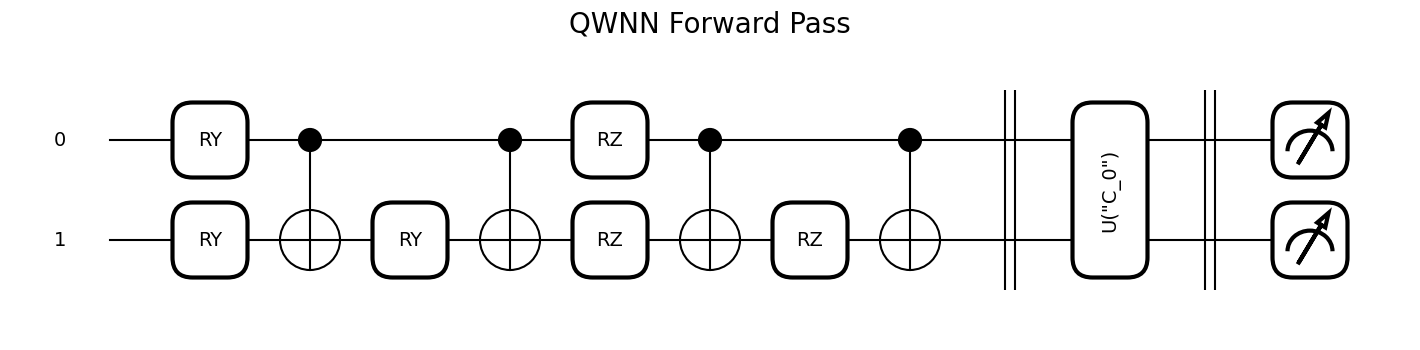

In [94]:
fig, ax = qml.draw_mpl(quantum_step_layer)(0, np.random.randn(2**n_qubits), barrier=True)

ax.set_title("QWNN Forward Pass", fontsize=20)
plt.show()

### Algorithm

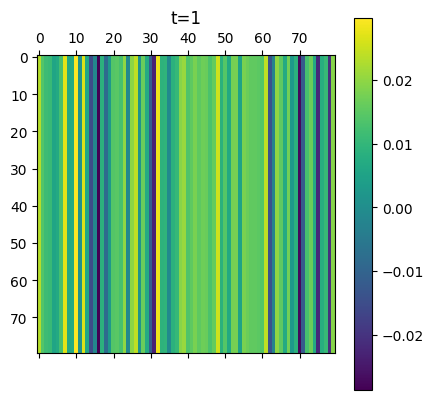

None

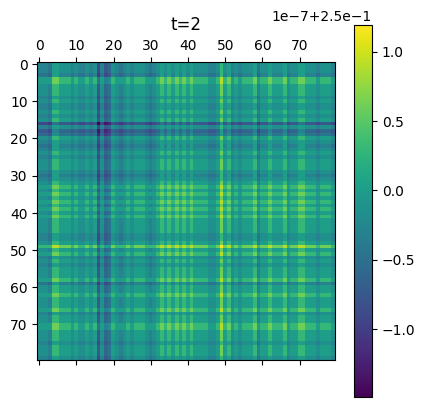

None

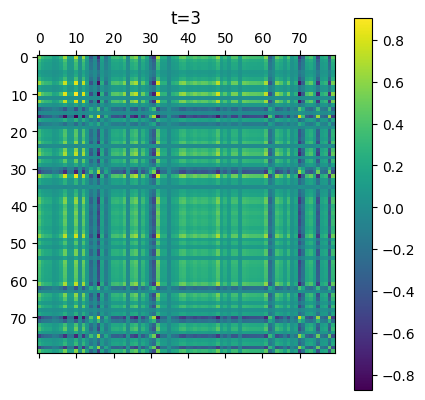

None

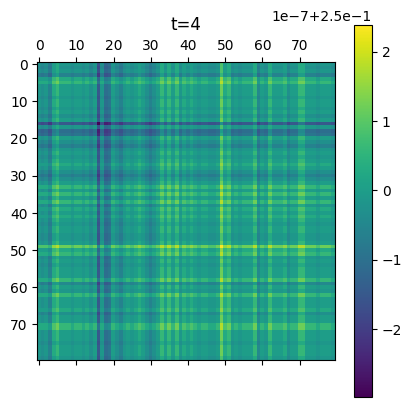

None

In [97]:
phi      = square_normalize(torch.ones(2**(n_qubits*int(np.ceil(np.log2(num_nodes))))))
phi_prev = square_normalize(torch.ones(2**(n_qubits*int(np.ceil(np.log2(num_nodes))))))
# print(torch.sum(torch.pow(phi, 2))) # verify that the statevector is valid 
for t in range(1, T+1):
    for i in range(num_nodes):
        phi[i*2**n_qubits:(i+1)*2**n_qubits] = quantum_step_layer(i, phi=phi_prev[i*2**n_qubits:(i+1)*2**n_qubits])
        # fig = plt.figure()
        # plt.bar(range(len(phi)), torch.abs(phi**2))
        # plt.set_title = f"t =  {t}"
        # display(fig.show())
        # if t==T-1:
        #     display(plt.matshow(torch.outer(phi[i:i+2**n_qubits], 
        #                                     phi_prev[i:i+2**n_qubits]))) # out of memory
        #     plt.show()
    (plt.matshow(torch.outer(torch.real(phi_prev[0:2**(n_qubits)*num_nodes]), 
                                    torch.real(phi[0:2**(n_qubits)*num_nodes])))) # out of memory
    plt.title(f"t={t}")
    plt.colorbar()
    display(plt.show())
    phi_prev = phi
# print(torch.abs(phi))
# print(phi.shape)

In [96]:
print(P.shape)
print(phi.shape)

torch.Size([20, 20])
torch.Size([1024])
